## Neste exemplo, compararemos o gradiente descendente estocástico sem e com a redução gradual do passo de aprendizagem.

In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import random

In [2]:
# Always reset the pseudo random number generator to the same number.
seed = 2
np.random.seed(seed)
random.seed(seed) # reset PN sequence generator for the "sample" function.

### Definição de funções úteis.

In [3]:
def calculateErrorSurface(X, y):
    '''Generate data points for plotting the error surface.'''

    # Get the number of examples.
    N = len(y)

    # Generate values for parameter space.
    M = 200
    a1 = np.linspace(-12.0, 14.0, M)
    a2 = np.linspace(-12.0, 14.0, M)

    # Generate the mesh grid.
    A1, A2 = np.meshgrid(a1, a2)

    # Get the attributes
    x1 = X[:,0].reshape(N, 1)
    x2 = X[:,1].reshape(N, 1)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M,M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            # Hypothesis function.
            yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
            # MSE for the current hypothesis function.
            J[iter1, iter2] = (1.0/N)*np.sum(np.square(y - yhat))

    return J, A1, A2

def calculateClosedFormSolution(X, y):
    """Calculate closed-form solution using the normal equation."""
    # Get the number of examples.
    N = len(y)
    # Closed-form solution.
    a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y))
    yhat = X.dot(a_opt)
    Joptimum = (1.0/N)*np.sum(np.power((y - yhat), 2))

    return Joptimum, a_opt

### As funções abaixo implementam as três técnicas para redução do passo de aprendizagem.

In [4]:
# Learning decay: Step decay.
def stepDecay(alpha_init, t, beta=6.0, tau=0.5):
    '''Gradual decay.'''
    alpha = alpha_init * math.pow(tau, math.floor((t+1)/beta))
    return alpha

# Learning decay: Exponential decay.
def exponentialDecay(alpha_init, t, k=0.01):
    '''Exponential decay.'''
    return alpha_init * np.exp(-k*t)

# Learning decay: Temporal decay.
def timeBasedDecay(alpha_init, t, k=0.01):
    '''Temporal decay.'''
    return alpha_init / (1.0 + k*t)

# Função usada para escolher qual será a redução gradual do passo de aprendizagem que será utilizada.
def learningDecay(typels, alpha_init, t):
    '''Funtion used to choose among some learning decay implementations.'''
    if(typels=='exp'):
        alpha = exponentialDecay(alpha_init, t)
    elif(typels=='time'):
        alpha = timeBasedDecay(alpha_init, t)
    elif(typels=='step'):
        alpha = stepDecay(alpha_init, t)
    else:
        alpha = alpha_init
    return alpha

### A função abaixo implementa o gradiente descendente estocástico com a possibilidade de habilitarmos ou não o uso de uma técnica de redução do passo passo de aprendizagem.

**OBS**.: A função armazena os vetores gradiente e de atualização (i.e., vetor gradiente vezes o passo de aprendizagem) de cada iteração.

In [5]:
# Gradiente descendente estocástico.
def gradientDescent(X, y, n_epochs, alpha_init, lrdecay='None', seed=42):
    '''Function implementing the stocastic version of the gradient descent with learning rate decay.'''

    # Retrieve the number of samples.
    N = len(y)

    # Reset the PN sequence generator.
    random.seed(seed)

    # Create vector for storing alpha history.
    alpha_hist = np.zeros((n_epochs*N))

    # Create vector for storing weight atualization history.
    a_hist = np.zeros((2, n_epochs*N+1))

    # Create array for storing error values.
    Jgd = np.zeros(n_epochs*N+1)

    # Create array for storing update history, i.e., learning rate times gradient vector.
    update_hist = np.zeros((2, n_epochs*N))

    # Create array for storing the gradient vector.
    gradient_hist = np.zeros((2, n_epochs*N))

    # Initialization of weights.
    a = np.array([-10.0, -10.0]).reshape(2, 1)

    # Initialize weight history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Calculate the initial error.
    Jgd[0] = (1.0/N)*sum(np.power(y - X.dot(a), 2))

    # Stocastic gradient-descent loop.
    iteration = 0
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_data_set_indexes = random.sample(range(0, N), N)

        # Go over the iterations, one sample at a time.
        for i in range(N):
            # Select ONE pair sample/label from the dataset.
            random_index = shuffled_data_set_indexes[i]
            xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]

            # Select the learning rate.
            alpha = learningDecay(lrdecay, alpha_init, epoch*N + i)

            # Update the weights.
            gradient = -1*xi.T.dot(yi - xi.dot(a))
            update = alpha*gradient
            a = a - update

            # Store current values.
            a_hist[:, epoch*N+i+1] = a.reshape(2,)
            alpha_hist[epoch*N+i] = alpha
            update_hist[:, epoch*N+i] = update.reshape(2,)
            gradient_hist[:, epoch*N+i] = gradient.reshape(2,)

            # Calculate error for current iteration.
            Jgd[epoch*N+i+1] = (1.0/N)*sum(np.power((y - X.dot(a)), 2))

            # Increment the iteration number.
            iteration = epoch*N+i

    return a, Jgd, a_hist, alpha_hist, update_hist, gradient_hist, iteration

### Gerando a função observável.

Usaremos a seguinte função objetivo (i.e., plano)

$$y = a_1 x_1 + a_2 x_2,$$

onde $a_1$ e $a_2$ são iguais a 1 e $x_1$ e $x_2$ são valores retirados da distribuição Gaussiana Normal Padrão.

$$y_{noisy} = y + w,$$
onde $w$ é o ruído adicionado às amostras e segue a distribuição Gaussiana Normal Padrão.

A função hipótese que será usada é dada por
$$h(\textbf{x}) = \hat{a}_1 x_1 + \hat{a}_2 x_2,$$

a qual pode ser representada matricialmente como

$$\textbf{h}(\textbf{X}) = \hat{\textbf{y}} = \textbf{X}\hat{\textbf{a}}.$$

A matriz de atributos, $\textbf{X}$, é criada concatenando-se os atributos $x_1$ e $x_2$.

In [6]:
# Define the number of examples.
N = 1000

# Features.
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable function.
y_noisy = y + w

# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

### Plotando as funções objetivo e observável.

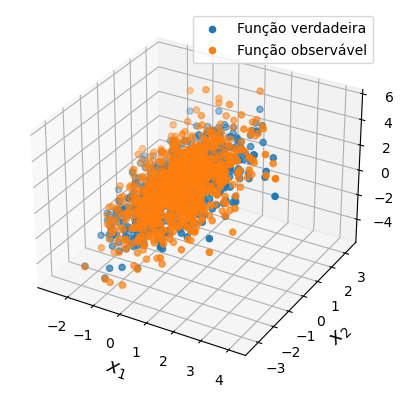

In [7]:
# Plot observable function.
fig = plt.figure()
plt.subplot(projection='3d')
ax = fig.gca()

ax.scatter(x1,x2,y, label='Função verdadeira')
ax.scatter(x1,x2,y_noisy, label='Função observável')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$y$', fontsize=14)
plt.legend()
plt.show()

### Plotando a superfície de erro.

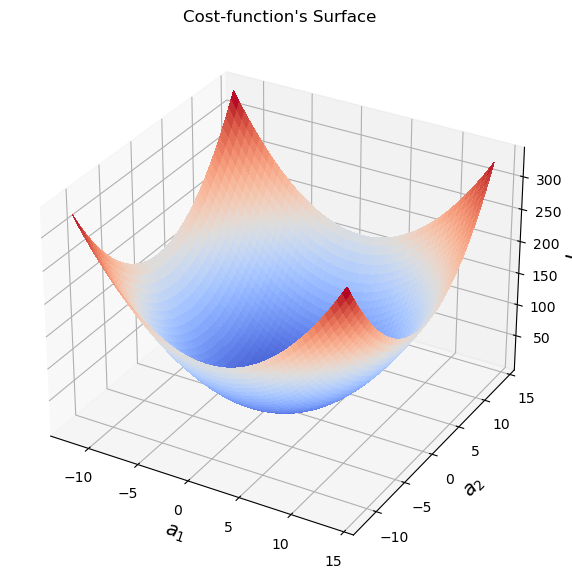

In [8]:
# Calculating the points to plot the error surface.
J, A1, A2 = calculateErrorSurface(X, y_noisy)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
# Show the plot.
plt.show()

### Encontrando a solução ótima com a equação normal.

In [9]:
# Calculate the optimum weights with the closed-form solution.
Joptimum, a_opt = calculateClosedFormSolution(X, y_noisy)

# Print a1 and a2 weights.
print('peso a1:', a_opt[0, 0])
print('peso a2:', a_opt[1, 0])

# Plot the MSE.
print('Erro:', Joptimum)

peso a1: 0.98225721822437
peso a2: 1.0387421041101124
Erro: 1.062891923320523


### Encontrando os pesos com o gradiente descendente estocástico.

In [10]:
# Number of epochs.
n_epochs = 1

# Learning rate decay technique.
lrdecay = 'none' # sem o uso de nenhuma abordagem de redução programada do passo de aprendizagem.

# Os valores ideais (encontrados por tentativa e erro) dos hiperparâmetros do decaimento em degraus são beta=6 e tau=0.5.
#lrdecay = 'step' # decaimento por degraus do passo de aprendizagem.

# Initial learning rate.
alpha_init = 0.3

# Stocastic gradient-descent version.
a, Jgd, a_hist, alpha_hist, update_hist, gradient_hist, iteration = gradientDescent(X, y_noisy, n_epochs, alpha_init, lrdecay, seed)

### Plotando a superfície de contorno com o histórico de atualização dos pesos.

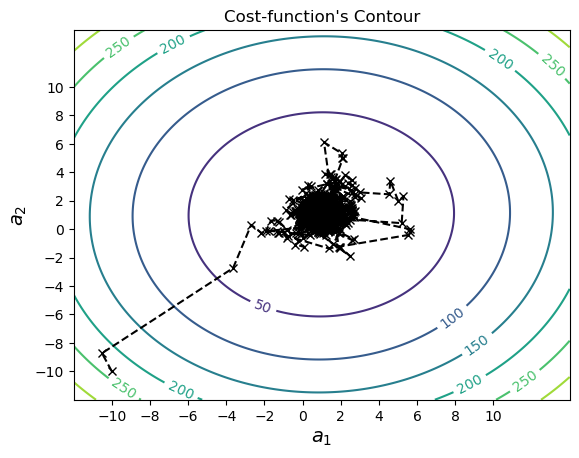

In [11]:
# Plot figure.
fig = plt.figure()
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*', markersize=12)
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 12, step=2.0))
plt.yticks(np.arange(-10, 12, step=2.0))
plt.show()

### Comparando os valores dos pesos.

In [12]:
# Print found values.
print('a1_opt: ' + str(a_opt[0, 0]))
print('a2_opt: ' + str(a_opt[1, 0]))
print('')

print('a1_sgd: ' + str(a[0, 0]))
print('a2_sgd: ' + str(a[1, 0]))

a1_opt: 0.98225721822437
a2_opt: 1.0387421041101124

a1_sgd: 0.3431455136827888
a2_sgd: 0.6967913408595582


#### Observação

+ Sem nenhuma redução do valor do passo de aprendizagem, os valores finais dos pesos podem não estar próximos dos valores ótimos devido ao ruído presente nas aproximações do vetor gradiente.

### Plotando a variação do passo de aprendizagem.

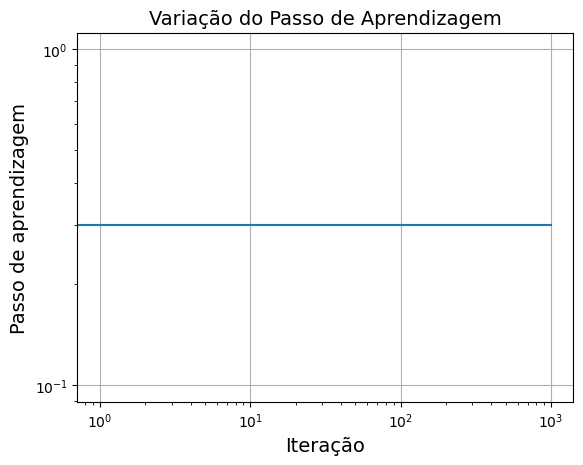

In [13]:
# Plot alpha history
fig = plt.figure()
plt.plot(range(0, n_epochs*N), alpha_hist)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Iteração', fontsize=14)
plt.ylabel('Passo de aprendizagem', fontsize=14)
plt.title('Variação do Passo de Aprendizagem', fontsize=14)
plt.grid()
plt.show()

### Plotando MSE em função das iterações.

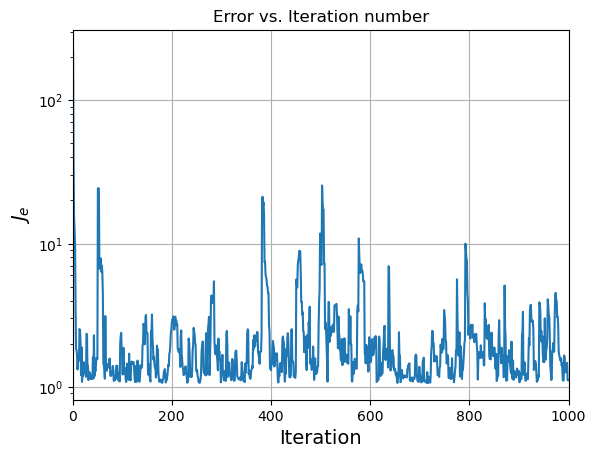

In [14]:
fig = plt.figure()
plt.plot(np.arange(0, n_epochs*N), Jgd[0:n_epochs*N])
plt.xlim((0, n_epochs*N))
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.grid()
plt.show()

### Plotando a variação do gradiente ao longo das iterações.

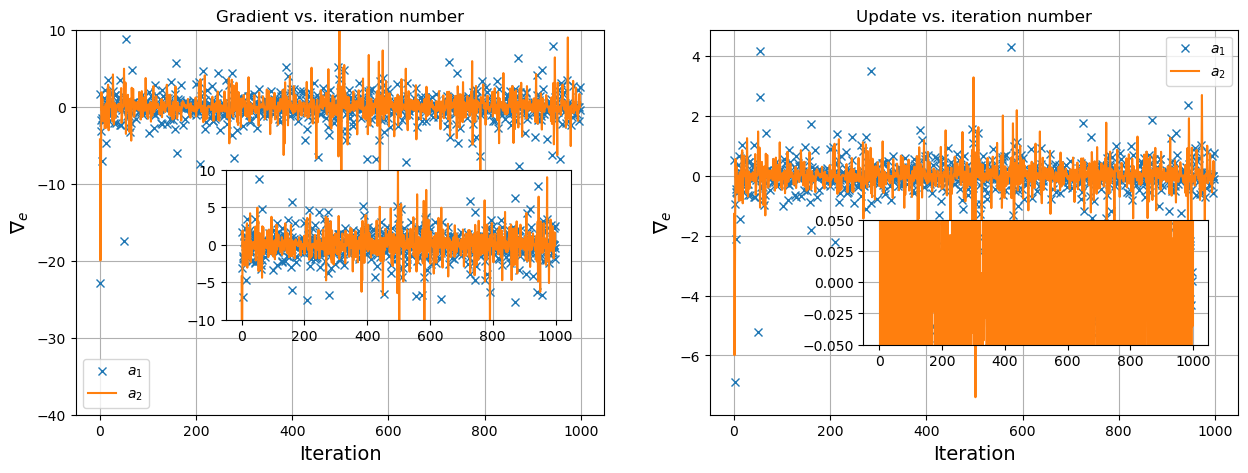

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.arange(0, n_epochs*N), gradient_hist[0, :], 'x', label='$a_1$')
ax1.plot(np.arange(0, n_epochs*N), gradient_hist[1, :], label='$a_2$')
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('$\\nabla_e$', fontsize=14)
ax1.set_title('Gradient vs. iteration number')
ax1.set_ylim(-40,10)
ax1.legend()
ax1.grid()

ax2.plot(np.arange(0, n_epochs*N), update_hist[0, :], 'x', label='$a_1$')
ax2.plot(np.arange(0, n_epochs*N), update_hist[1, :], label='$a_2$')
ax2.set_xlabel('Iteration', fontsize=14)
ax2.set_ylabel('$\\nabla_e$', fontsize=14)
ax2.set_title('Update vs. iteration number')
ax2.legend()
ax2.grid()

left, bottom, width, height = [0.225, 0.3, 0.23, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot(np.arange(0, n_epochs*N), gradient_hist[0, :], 'x')
ax3.plot(np.arange(0, n_epochs*N), gradient_hist[1, :])
ax3.set_ylim(-10,10)
ax3.grid()

left, bottom, width, height = [0.65, 0.25, 0.23, 0.25]
ax4 = fig.add_axes([left, bottom, width, height])
ax4.plot(np.arange(0, n_epochs*N), update_hist[0, :], 'x')
ax4.plot(np.arange(0, n_epochs*N), update_hist[1, :])
ax4.set_ylim(-0.05, 0.05)
ax4.grid()

plt.show()

### Conclusões

+ Assim como com o GDE, o **caminho com o decaimento gradual também não é regular** até o ponto de mínimo, apresentando **mudanças de direção** ao longo do caminho.
<br/><br/>

+ A **redução do passo de aprendizagem não afeta a direção apontada do vetor gradiente**, apenas o tamanho do passo dado em direção à máxima declividade da função.
    + Por ser sempre um valor positivo, o passo de aprendizagem afeta apenas a magnitude do vetor gradiente.
    + O que a redução do passo de aprendizagem faz é restringir a movimentação, ou seja, a atualização dos pesos, (encurtar o passo dado em direção ao mínimo), principalmente, quando o GDE estiver próximo do ponto de mínimo global, fazendo com que ele se mova muito pouco ao redor dele.
<br/><br/>

+ A redução gradual do passo faz com que a **oscilação em torno do mínimo seja bastante reduzida**, fazendo com que o algoritmo se **estabilize próximo ao ponto de mínimo global**.
<br/><br/>

+ A redução gradual do valor do passo de aprendizagem faz com que o **termo de atualização dos pesos se torne muito pequeno (tendendo a zero)** quando o algortimo de GDE estiver próximo do ponto de mínimo global.
    + Isto faz com que o GDE se estabilize, **convergindo forçadamente** (devido a anulação do vetor gradiente ruidoso) para as proximidades do ponto de mínimo global.